In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV4'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v4(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64, 16)         64        
_________________________________________________________________
dense (Dense)                (None, 1, 64, 256)        4352  

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/162 [..............................] - ETA: 36:16 - loss: 2.8780

  4/162 [..............................] - ETA: 3s - loss: 2.7906   

  7/162 [>.............................] - ETA: 3s - loss: 2.7201

 10/162 [>.............................] - ETA: 3s - loss: 2.6610

 13/162 [=>............................] - ETA: 3s - loss: 2.6101

 16/162 [=>............................] - ETA: 3s - loss: 2.5672

 19/162 [==>...........................] - ETA: 3s - loss: 2.5294

 22/162 [===>..........................] - ETA: 3s - loss: 2.4955

 24/162 [===>..........................] - ETA: 3s - loss: 2.4746

 27/162 [====>.........................] - ETA: 3s - loss: 2.4451

 30/162 [====>.........................] - ETA: 3s - loss: 2.4178

 33/162 [=====>........................] - ETA: 3s - loss: 2.3925

 36/162 [=====>........................] - ETA: 3s - loss: 2.3689

 39/162 [======>.......................] - ETA: 2s - loss: 2.3469

 42/162 [======>.......................] - ETA: 2s - loss: 2.3262

 45/162 [=======>......................] - ETA: 2s - loss: 2.3066

 48/162 [=======>......................] - ETA: 2s - loss: 2.2882

 51/162 [========>.....................] - ETA: 2s - loss: 2.2708

 54/162 [=========>....................] - ETA: 2s - loss: 2.2542

 57/162 [=========>....................] - ETA: 2s - loss: 2.2384

 60/162 [==========>...................] - ETA: 2s - loss: 2.2233

 63/162 [==========>...................] - ETA: 2s - loss: 2.2090

 66/162 [===========>..................] - ETA: 2s - loss: 2.1953

 69/162 [===========>..................] - ETA: 2s - loss: 2.1822

 72/162 [============>.................] - ETA: 2s - loss: 2.1696

 75/162 [============>.................] - ETA: 2s - loss: 2.1576

 78/162 [=============>................] - ETA: 2s - loss: 2.1460

 81/162 [==============>...............] - ETA: 1s - loss: 2.1348

 84/162 [==============>...............] - ETA: 1s - loss: 2.1240

 87/162 [===============>..............] - ETA: 1s - loss: 2.1136

 90/162 [===============>..............] - ETA: 1s - loss: 2.1036

 93/162 [================>.............] - ETA: 1s - loss: 2.0938

 96/162 [================>.............] - ETA: 1s - loss: 2.0844

 99/162 [=================>............] - ETA: 1s - loss: 2.0752

102/162 [=================>............] - ETA: 1s - loss: 2.0663

105/162 [==================>...........] - ETA: 1s - loss: 2.0577

108/162 [===================>..........] - ETA: 1s - loss: 2.0493

111/162 [===================>..........] - ETA: 1s - loss: 2.0411

114/162 [====================>.........] - ETA: 1s - loss: 2.0332

117/162 [====================>.........] - ETA: 1s - loss: 2.0255

120/162 [=====================>........] - ETA: 1s - loss: 2.0179

123/162 [=====================>........] - ETA: 0s - loss: 2.0106

126/162 [======================>.......] - ETA: 0s - loss: 2.0035

129/162 [======================>.......] - ETA: 0s - loss: 1.9965

132/162 [=======================>......] - ETA: 0s - loss: 1.9896

135/162 [========================>.....] - ETA: 0s - loss: 1.9830

138/162 [========================>.....] - ETA: 0s - loss: 1.9765

141/162 [=========================>....] - ETA: 0s - loss: 1.9701

144/162 [=========================>....] - ETA: 0s - loss: 1.9639

147/162 [==========================>...] - ETA: 0s - loss: 1.9578

149/162 [==========================>...] - ETA: 0s - loss: 1.9538

152/162 [===========================>..] - ETA: 0s - loss: 1.9480

155/162 [===========================>..] - ETA: 0s - loss: 1.9423

158/162 [============================>.] - ETA: 0s - loss: 1.9366

161/162 [============================>.] - ETA: 0s - loss: 1.9311

162/162 [==============================] - ETA: 0s - loss: 1.9293

162/162 [==============================] - 19s 31ms/step - loss: 1.9276 - val_loss: 8.5480


Epoch 2/100
  1/162 [..............................] - ETA: 3s - loss: 1.3631

  4/162 [..............................] - ETA: 3s - loss: 1.3878

  7/162 [>.............................] - ETA: 3s - loss: 1.3893

 10/162 [>.............................] - ETA: 3s - loss: 1.3872

 12/162 [=>............................] - ETA: 3s - loss: 1.3859

 15/162 [=>............................] - ETA: 3s - loss: 1.3844

 18/162 [==>...........................] - ETA: 3s - loss: 1.3828

 21/162 [==>...........................] - ETA: 3s - loss: 1.3811

 24/162 [===>..........................] - ETA: 3s - loss: 1.3799

 27/162 [====>.........................] - ETA: 3s - loss: 1.3789

 30/162 [====>.........................] - ETA: 3s - loss: 1.3778

 33/162 [=====>........................] - ETA: 3s - loss: 1.3766

 36/162 [=====>........................] - ETA: 3s - loss: 1.3754

 39/162 [======>.......................] - ETA: 2s - loss: 1.3743

 42/162 [======>.......................] - ETA: 2s - loss: 1.3734

 45/162 [=======>......................] - ETA: 2s - loss: 1.3725

 48/162 [=======>......................] - ETA: 2s - loss: 1.3718

 51/162 [========>.....................] - ETA: 2s - loss: 1.3711

 54/162 [=========>....................] - ETA: 2s - loss: 1.3703

 57/162 [=========>....................] - ETA: 2s - loss: 1.3697

 59/162 [=========>....................] - ETA: 2s - loss: 1.3692

 62/162 [==========>...................] - ETA: 2s - loss: 1.3686

 65/162 [===========>..................] - ETA: 2s - loss: 1.3680

 68/162 [===========>..................] - ETA: 2s - loss: 1.3674

 71/162 [============>.................] - ETA: 2s - loss: 1.3668

 74/162 [============>.................] - ETA: 2s - loss: 1.3663

 77/162 [=============>................] - ETA: 2s - loss: 1.3657

 80/162 [=============>................] - ETA: 1s - loss: 1.3652

 83/162 [==============>...............] - ETA: 1s - loss: 1.3648

 86/162 [==============>...............] - ETA: 1s - loss: 1.3643

 89/162 [===============>..............] - ETA: 1s - loss: 1.3638

 92/162 [================>.............] - ETA: 1s - loss: 1.3634

 95/162 [================>.............] - ETA: 1s - loss: 1.3629

 98/162 [=================>............] - ETA: 1s - loss: 1.3625

101/162 [=================>............] - ETA: 1s - loss: 1.3620

104/162 [==================>...........] - ETA: 1s - loss: 1.3616

107/162 [==================>...........] - ETA: 1s - loss: 1.3612

110/162 [===================>..........] - ETA: 1s - loss: 1.3607

113/162 [===================>..........] - ETA: 1s - loss: 1.3603

116/162 [====================>.........] - ETA: 1s - loss: 1.3600

119/162 [=====================>........] - ETA: 1s - loss: 1.3596

122/162 [=====================>........] - ETA: 0s - loss: 1.3592

125/162 [======================>.......] - ETA: 0s - loss: 1.3589

128/162 [======================>.......] - ETA: 0s - loss: 1.3585

131/162 [=======================>......] - ETA: 0s - loss: 1.3581

134/162 [=======================>......] - ETA: 0s - loss: 1.3577

137/162 [========================>.....] - ETA: 0s - loss: 1.3573

140/162 [========================>.....] - ETA: 0s - loss: 1.3570

143/162 [=========================>....] - ETA: 0s - loss: 1.3566

146/162 [==========================>...] - ETA: 0s - loss: 1.3563

149/162 [==========================>...] - ETA: 0s - loss: 1.3559

152/162 [===========================>..] - ETA: 0s - loss: 1.3556

155/162 [===========================>..] - ETA: 0s - loss: 1.3553

158/162 [============================>.] - ETA: 0s - loss: 1.3549

161/162 [============================>.] - ETA: 0s - loss: 1.3546

162/162 [==============================] - 4s 27ms/step - loss: 1.3544 - val_loss: 11.5507


Epoch 3/100
  1/162 [..............................] - ETA: 3s - loss: 1.2502

  4/162 [..............................] - ETA: 3s - loss: 1.2853

  7/162 [>.............................] - ETA: 3s - loss: 1.2877

 10/162 [>.............................] - ETA: 3s - loss: 1.2900

 13/162 [=>............................] - ETA: 3s - loss: 1.2933

 16/162 [=>............................] - ETA: 3s - loss: 1.2953

 19/162 [==>...........................] - ETA: 3s - loss: 1.2962

 22/162 [===>..........................] - ETA: 3s - loss: 1.2969

 25/162 [===>..........................] - ETA: 3s - loss: 1.2971

 28/162 [====>.........................] - ETA: 3s - loss: 1.2971

 31/162 [====>.........................] - ETA: 3s - loss: 1.2968

 34/162 [=====>........................] - ETA: 3s - loss: 1.2966

 37/162 [=====>........................] - ETA: 3s - loss: 1.2964

 40/162 [======>.......................] - ETA: 2s - loss: 1.2962

 43/162 [======>.......................] - ETA: 2s - loss: 1.2961

 46/162 [=======>......................] - ETA: 2s - loss: 1.2958

 49/162 [========>.....................] - ETA: 2s - loss: 1.2955

 52/162 [========>.....................] - ETA: 2s - loss: 1.2953

 55/162 [=========>....................] - ETA: 2s - loss: 1.2951

 58/162 [=========>....................] - ETA: 2s - loss: 1.2950

 61/162 [==========>...................] - ETA: 2s - loss: 1.2949

 64/162 [==========>...................] - ETA: 2s - loss: 1.2949

 67/162 [===========>..................] - ETA: 2s - loss: 1.2948

 70/162 [===========>..................] - ETA: 2s - loss: 1.2948

 73/162 [============>.................] - ETA: 2s - loss: 1.2947

 76/162 [=============>................] - ETA: 2s - loss: 1.2946

 79/162 [=============>................] - ETA: 1s - loss: 1.2945

 82/162 [==============>...............] - ETA: 1s - loss: 1.2944

 85/162 [==============>...............] - ETA: 1s - loss: 1.2943

 88/162 [===============>..............] - ETA: 1s - loss: 1.2942

 91/162 [===============>..............] - ETA: 1s - loss: 1.2940

 94/162 [================>.............] - ETA: 1s - loss: 1.2939

 97/162 [================>.............] - ETA: 1s - loss: 1.2938

100/162 [=================>............] - ETA: 1s - loss: 1.2937

103/162 [==================>...........] - ETA: 1s - loss: 1.2935

106/162 [==================>...........] - ETA: 1s - loss: 1.2934

109/162 [===================>..........] - ETA: 1s - loss: 1.2933

112/162 [===================>..........] - ETA: 1s - loss: 1.2932

115/162 [====================>.........] - ETA: 1s - loss: 1.2931

118/162 [====================>.........] - ETA: 1s - loss: 1.2930

121/162 [=====================>........] - ETA: 0s - loss: 1.2929

124/162 [=====================>........] - ETA: 0s - loss: 1.2928

127/162 [======================>.......] - ETA: 0s - loss: 1.2927

130/162 [=======================>......] - ETA: 0s - loss: 1.2925

132/162 [=======================>......] - ETA: 0s - loss: 1.2924

135/162 [========================>.....] - ETA: 0s - loss: 1.2923

138/162 [========================>.....] - ETA: 0s - loss: 1.2922

141/162 [=========================>....] - ETA: 0s - loss: 1.2921

144/162 [=========================>....] - ETA: 0s - loss: 1.2919

147/162 [==========================>...] - ETA: 0s - loss: 1.2918

150/162 [==========================>...] - ETA: 0s - loss: 1.2917

153/162 [===========================>..] - ETA: 0s - loss: 1.2915

156/162 [===========================>..] - ETA: 0s - loss: 1.2914

159/162 [============================>.] - ETA: 0s - loss: 1.2913



162/162 [==============================] - ETA: 0s - loss: 1.2911

162/162 [==============================] - 4s 27ms/step - loss: 1.2911 - val_loss: 5.2056


Epoch 4/100


  1/162 [..............................] - ETA: 3s - loss: 1.2401

  4/162 [..............................] - ETA: 3s - loss: 1.2511

  7/162 [>.............................] - ETA: 3s - loss: 1.2552

 10/162 [>.............................] - ETA: 3s - loss: 1.2571

 13/162 [=>............................] - ETA: 3s - loss: 1.2583

 16/162 [=>............................] - ETA: 3s - loss: 1.2589

 19/162 [==>...........................] - ETA: 3s - loss: 1.2595

 22/162 [===>..........................] - ETA: 3s - loss: 1.2599

 25/162 [===>..........................] - ETA: 3s - loss: 1.2601

 27/162 [====>.........................] - ETA: 3s - loss: 1.2600

 30/162 [====>.........................] - ETA: 3s - loss: 1.2601

 33/162 [=====>........................] - ETA: 3s - loss: 1.2600

 36/162 [=====>........................] - ETA: 3s - loss: 1.2600

 39/162 [======>.......................] - ETA: 2s - loss: 1.2598

 42/162 [======>.......................] - ETA: 2s - loss: 1.2596

 45/162 [=======>......................] - ETA: 2s - loss: 1.2592

 48/162 [=======>......................] - ETA: 2s - loss: 1.2587

 51/162 [========>.....................] - ETA: 2s - loss: 1.2583

 54/162 [=========>....................] - ETA: 2s - loss: 1.2579

 57/162 [=========>....................] - ETA: 2s - loss: 1.2576

 60/162 [==========>...................] - ETA: 2s - loss: 1.2573

 63/162 [==========>...................] - ETA: 2s - loss: 1.2569

 66/162 [===========>..................] - ETA: 2s - loss: 1.2566

 69/162 [===========>..................] - ETA: 2s - loss: 1.2563

 72/162 [============>.................] - ETA: 2s - loss: 1.2560

 75/162 [============>.................] - ETA: 2s - loss: 1.2558

 78/162 [=============>................] - ETA: 2s - loss: 1.2556

 81/162 [==============>...............] - ETA: 1s - loss: 1.2553

 84/162 [==============>...............] - ETA: 1s - loss: 1.2551

 87/162 [===============>..............] - ETA: 1s - loss: 1.2548

 90/162 [===============>..............] - ETA: 1s - loss: 1.2546

 93/162 [================>.............] - ETA: 1s - loss: 1.2544

 96/162 [================>.............] - ETA: 1s - loss: 1.2542

 99/162 [=================>............] - ETA: 1s - loss: 1.2540

102/162 [=================>............] - ETA: 1s - loss: 1.2538

105/162 [==================>...........] - ETA: 1s - loss: 1.2536

108/162 [===================>..........] - ETA: 1s - loss: 1.2534

111/162 [===================>..........] - ETA: 1s - loss: 1.2532

114/162 [====================>.........] - ETA: 1s - loss: 1.2531

117/162 [====================>.........] - ETA: 1s - loss: 1.2529

120/162 [=====================>........] - ETA: 1s - loss: 1.2528

123/162 [=====================>........] - ETA: 0s - loss: 1.2527

126/162 [======================>.......] - ETA: 0s - loss: 1.2526

129/162 [======================>.......] - ETA: 0s - loss: 1.2525

132/162 [=======================>......] - ETA: 0s - loss: 1.2524

135/162 [========================>.....] - ETA: 0s - loss: 1.2523

138/162 [========================>.....] - ETA: 0s - loss: 1.2521

141/162 [=========================>....] - ETA: 0s - loss: 1.2520



143/162 [=========================>....] - ETA: 0s - loss: 1.2520

146/162 [==========================>...] - ETA: 0s - loss: 1.2519

149/162 [==========================>...] - ETA: 0s - loss: 1.2518

152/162 [===========================>..] - ETA: 0s - loss: 1.2517

155/162 [===========================>..] - ETA: 0s - loss: 1.2516

158/162 [============================>.] - ETA: 0s - loss: 1.2515

161/162 [============================>.] - ETA: 0s - loss: 1.2514

162/162 [==============================] - 4s 27ms/step - loss: 1.2513 - val_loss: 4.6787


Epoch 5/100
  1/162 [..............................] - ETA: 4s - loss: 1.2597

  3/162 [..............................] - ETA: 3s - loss: 1.2528

  6/162 [>.............................] - ETA: 3s - loss: 1.2455

  9/162 [>.............................] - ETA: 3s - loss: 1.2428

 12/162 [=>............................] - ETA: 3s - loss: 1.2411

 15/162 [=>............................] - ETA: 3s - loss: 1.2401

 18/162 [==>...........................] - ETA: 3s - loss: 1.2395

 21/162 [==>...........................] - ETA: 3s - loss: 1.2393

 24/162 [===>..........................] - ETA: 3s - loss: 1.2391

 27/162 [====>.........................] - ETA: 3s - loss: 1.2389

 30/162 [====>.........................] - ETA: 3s - loss: 1.2388

 33/162 [=====>........................] - ETA: 3s - loss: 1.2384

 36/162 [=====>........................] - ETA: 3s - loss: 1.2379

 39/162 [======>.......................] - ETA: 2s - loss: 1.2372

 42/162 [======>.......................] - ETA: 2s - loss: 1.2366

 45/162 [=======>......................] - ETA: 2s - loss: 1.2359

 48/162 [=======>......................] - ETA: 2s - loss: 1.2353

 51/162 [========>.....................] - ETA: 2s - loss: 1.2346

 54/162 [=========>....................] - ETA: 2s - loss: 1.2341

 57/162 [=========>....................] - ETA: 2s - loss: 1.2336

 60/162 [==========>...................] - ETA: 2s - loss: 1.2331

 63/162 [==========>...................] - ETA: 2s - loss: 1.2326

 66/162 [===========>..................] - ETA: 2s - loss: 1.2322

 69/162 [===========>..................] - ETA: 2s - loss: 1.2317

 72/162 [============>.................] - ETA: 2s - loss: 1.2312

 75/162 [============>.................] - ETA: 2s - loss: 1.2309

 78/162 [=============>................] - ETA: 2s - loss: 1.2305

 81/162 [==============>...............] - ETA: 1s - loss: 1.2301

 84/162 [==============>...............] - ETA: 1s - loss: 1.2298

 87/162 [===============>..............] - ETA: 1s - loss: 1.2296

 90/162 [===============>..............] - ETA: 1s - loss: 1.2293

 92/162 [================>.............] - ETA: 1s - loss: 1.2292

 95/162 [================>.............] - ETA: 1s - loss: 1.2290

 98/162 [=================>............] - ETA: 1s - loss: 1.2288

101/162 [=================>............] - ETA: 1s - loss: 1.2286

104/162 [==================>...........] - ETA: 1s - loss: 1.2285

107/162 [==================>...........] - ETA: 1s - loss: 1.2284

110/162 [===================>..........] - ETA: 1s - loss: 1.2283

113/162 [===================>..........] - ETA: 1s - loss: 1.2282

116/162 [====================>.........] - ETA: 1s - loss: 1.2281

119/162 [=====================>........] - ETA: 1s - loss: 1.2280

122/162 [=====================>........] - ETA: 0s - loss: 1.2279

125/162 [======================>.......] - ETA: 0s - loss: 1.2277

128/162 [======================>.......] - ETA: 0s - loss: 1.2276

131/162 [=======================>......] - ETA: 0s - loss: 1.2275

133/162 [=======================>......] - ETA: 0s - loss: 1.2274

136/162 [========================>.....] - ETA: 0s - loss: 1.2273

139/162 [========================>.....] - ETA: 0s - loss: 1.2272

142/162 [=========================>....] - ETA: 0s - loss: 1.2271

145/162 [=========================>....] - ETA: 0s - loss: 1.2270

148/162 [==========================>...] - ETA: 0s - loss: 1.2269

151/162 [==========================>...] - ETA: 0s - loss: 1.2268

154/162 [===========================>..] - ETA: 0s - loss: 1.2268

157/162 [============================>.] - ETA: 0s - loss: 1.2267

160/162 [============================>.] - ETA: 0s - loss: 1.2266

162/162 [==============================] - 4s 27ms/step - loss: 1.2266 - val_loss: 1.3272


Epoch 6/100
  1/162 [..............................] - ETA: 4s - loss: 1.1904

  4/162 [..............................] - ETA: 3s - loss: 1.2079

  7/162 [>.............................] - ETA: 3s - loss: 1.2152

 10/162 [>.............................] - ETA: 3s - loss: 1.2181

 13/162 [=>............................] - ETA: 3s - loss: 1.2192

 16/162 [=>............................] - ETA: 3s - loss: 1.2198

 19/162 [==>...........................] - ETA: 3s - loss: 1.2202

 22/162 [===>..........................] - ETA: 3s - loss: 1.2202

 25/162 [===>..........................] - ETA: 3s - loss: 1.2196

 28/162 [====>.........................] - ETA: 3s - loss: 1.2192

 31/162 [====>.........................] - ETA: 3s - loss: 1.2191

 34/162 [=====>........................] - ETA: 3s - loss: 1.2189

 37/162 [=====>........................] - ETA: 2s - loss: 1.2187

 40/162 [======>.......................] - ETA: 2s - loss: 1.2184

 43/162 [======>.......................] - ETA: 2s - loss: 1.2183

 46/162 [=======>......................] - ETA: 2s - loss: 1.2180

 49/162 [========>.....................] - ETA: 2s - loss: 1.2179

 52/162 [========>.....................] - ETA: 2s - loss: 1.2176

 55/162 [=========>....................] - ETA: 2s - loss: 1.2174

 58/162 [=========>....................] - ETA: 2s - loss: 1.2171

 61/162 [==========>...................] - ETA: 2s - loss: 1.2170

 64/162 [==========>...................] - ETA: 2s - loss: 1.2168

 67/162 [===========>..................] - ETA: 2s - loss: 1.2166

 70/162 [===========>..................] - ETA: 2s - loss: 1.2165

 73/162 [============>.................] - ETA: 2s - loss: 1.2163

 75/162 [============>.................] - ETA: 2s - loss: 1.2163

 78/162 [=============>................] - ETA: 2s - loss: 1.2161

 81/162 [==============>...............] - ETA: 1s - loss: 1.2160

 84/162 [==============>...............] - ETA: 1s - loss: 1.2159

 87/162 [===============>..............] - ETA: 1s - loss: 1.2158

 90/162 [===============>..............] - ETA: 1s - loss: 1.2156

 93/162 [================>.............] - ETA: 1s - loss: 1.2155

 96/162 [================>.............] - ETA: 1s - loss: 1.2154

 99/162 [=================>............] - ETA: 1s - loss: 1.2153

102/162 [=================>............] - ETA: 1s - loss: 1.2153

105/162 [==================>...........] - ETA: 1s - loss: 1.2152

108/162 [===================>..........] - ETA: 1s - loss: 1.2151

111/162 [===================>..........] - ETA: 1s - loss: 1.2150

114/162 [====================>.........] - ETA: 1s - loss: 1.2149

117/162 [====================>.........] - ETA: 1s - loss: 1.2148

120/162 [=====================>........] - ETA: 1s - loss: 1.2147

123/162 [=====================>........] - ETA: 0s - loss: 1.2146

126/162 [======================>.......] - ETA: 0s - loss: 1.2145

129/162 [======================>.......] - ETA: 0s - loss: 1.2144

132/162 [=======================>......] - ETA: 0s - loss: 1.2143

135/162 [========================>.....] - ETA: 0s - loss: 1.2141

138/162 [========================>.....] - ETA: 0s - loss: 1.2140

141/162 [=========================>....] - ETA: 0s - loss: 1.2139

144/162 [=========================>....] - ETA: 0s - loss: 1.2137

147/162 [==========================>...] - ETA: 0s - loss: 1.2136

150/162 [==========================>...] - ETA: 0s - loss: 1.2135

153/162 [===========================>..] - ETA: 0s - loss: 1.2134

155/162 [===========================>..] - ETA: 0s - loss: 1.2133

158/162 [============================>.] - ETA: 0s - loss: 1.2132

161/162 [============================>.] - ETA: 0s - loss: 1.2131

162/162 [==============================] - 4s 27ms/step - loss: 1.2131 - val_loss: 1.2327


Epoch 7/100
  1/162 [..............................] - ETA: 3s - loss: 1.2141

  4/162 [..............................] - ETA: 3s - loss: 1.2037

  7/162 [>.............................] - ETA: 3s - loss: 1.1960

 10/162 [>.............................] - ETA: 3s - loss: 1.1924

 13/162 [=>............................] - ETA: 3s - loss: 1.1920

 16/162 [=>............................] - ETA: 3s - loss: 1.1931

 19/162 [==>...........................] - ETA: 3s - loss: 1.1940

 22/162 [===>..........................] - ETA: 3s - loss: 1.1950

 25/162 [===>..........................] - ETA: 3s - loss: 1.1955

 28/162 [====>.........................] - ETA: 3s - loss: 1.1958

 31/162 [====>.........................] - ETA: 3s - loss: 1.1959

 34/162 [=====>........................] - ETA: 3s - loss: 1.1959

 37/162 [=====>........................] - ETA: 3s - loss: 1.1961

 40/162 [======>.......................] - ETA: 2s - loss: 1.1961

 43/162 [======>.......................] - ETA: 2s - loss: 1.1961

 46/162 [=======>......................] - ETA: 2s - loss: 1.1961

 49/162 [========>.....................] - ETA: 2s - loss: 1.1961

 52/162 [========>.....................] - ETA: 2s - loss: 1.1961

 55/162 [=========>....................] - ETA: 2s - loss: 1.1961

 58/162 [=========>....................] - ETA: 2s - loss: 1.1961

 61/162 [==========>...................] - ETA: 2s - loss: 1.1961

 64/162 [==========>...................] - ETA: 2s - loss: 1.1961

 67/162 [===========>..................] - ETA: 2s - loss: 1.1960

 70/162 [===========>..................] - ETA: 2s - loss: 1.1960

 73/162 [============>.................] - ETA: 2s - loss: 1.1959

 76/162 [=============>................] - ETA: 2s - loss: 1.1959

 79/162 [=============>................] - ETA: 1s - loss: 1.1958

 82/162 [==============>...............] - ETA: 1s - loss: 1.1957

 85/162 [==============>...............] - ETA: 1s - loss: 1.1956

 88/162 [===============>..............] - ETA: 1s - loss: 1.1955

 91/162 [===============>..............] - ETA: 1s - loss: 1.1954

 94/162 [================>.............] - ETA: 1s - loss: 1.1952

 97/162 [================>.............] - ETA: 1s - loss: 1.1951

100/162 [=================>............] - ETA: 1s - loss: 1.1950

103/162 [==================>...........] - ETA: 1s - loss: 1.1949

106/162 [==================>...........] - ETA: 1s - loss: 1.1948

109/162 [===================>..........] - ETA: 1s - loss: 1.1947

112/162 [===================>..........] - ETA: 1s - loss: 1.1946

115/162 [====================>.........] - ETA: 1s - loss: 1.1946

118/162 [====================>.........] - ETA: 1s - loss: 1.1945

121/162 [=====================>........] - ETA: 0s - loss: 1.1944

124/162 [=====================>........] - ETA: 0s - loss: 1.1944

127/162 [======================>.......] - ETA: 0s - loss: 1.1943

130/162 [=======================>......] - ETA: 0s - loss: 1.1943

133/162 [=======================>......] - ETA: 0s - loss: 1.1942

136/162 [========================>.....] - ETA: 0s - loss: 1.1942

139/162 [========================>.....] - ETA: 0s - loss: 1.1942

142/162 [=========================>....] - ETA: 0s - loss: 1.1942

145/162 [=========================>....] - ETA: 0s - loss: 1.1942

148/162 [==========================>...] - ETA: 0s - loss: 1.1942

151/162 [==========================>...] - ETA: 0s - loss: 1.1941

154/162 [===========================>..] - ETA: 0s - loss: 1.1941

157/162 [============================>.] - ETA: 0s - loss: 1.1941

160/162 [============================>.] - ETA: 0s - loss: 1.1941

162/162 [==============================] - 4s 27ms/step - loss: 1.1941 - val_loss: 1.1997


Epoch 8/100
  1/162 [..............................] - ETA: 4s - loss: 1.1589

  4/162 [..............................] - ETA: 3s - loss: 1.1541

  7/162 [>.............................] - ETA: 3s - loss: 1.1566

 10/162 [>.............................] - ETA: 3s - loss: 1.1603

 13/162 [=>............................] - ETA: 3s - loss: 1.1624

 16/162 [=>............................] - ETA: 3s - loss: 1.1638

 19/162 [==>...........................] - ETA: 3s - loss: 1.1647

 22/162 [===>..........................] - ETA: 3s - loss: 1.1658

 25/162 [===>..........................] - ETA: 3s - loss: 1.1670

 28/162 [====>.........................] - ETA: 3s - loss: 1.1681

 31/162 [====>.........................] - ETA: 3s - loss: 1.1689

 34/162 [=====>........................] - ETA: 3s - loss: 1.1695

 37/162 [=====>........................] - ETA: 3s - loss: 1.1701

 40/162 [======>.......................] - ETA: 2s - loss: 1.1707

 43/162 [======>.......................] - ETA: 2s - loss: 1.1712

 46/162 [=======>......................] - ETA: 2s - loss: 1.1718

 49/162 [========>.....................] - ETA: 2s - loss: 1.1722

 52/162 [========>.....................] - ETA: 2s - loss: 1.1726

 55/162 [=========>....................] - ETA: 2s - loss: 1.1730

 58/162 [=========>....................] - ETA: 2s - loss: 1.1735

 61/162 [==========>...................] - ETA: 2s - loss: 1.1739

 64/162 [==========>...................] - ETA: 2s - loss: 1.1744

 67/162 [===========>..................] - ETA: 2s - loss: 1.1748

 70/162 [===========>..................] - ETA: 2s - loss: 1.1752

 72/162 [============>.................] - ETA: 2s - loss: 1.1754

 75/162 [============>.................] - ETA: 2s - loss: 1.1757

 78/162 [=============>................] - ETA: 2s - loss: 1.1760

 81/162 [==============>...............] - ETA: 1s - loss: 1.1763

 84/162 [==============>...............] - ETA: 1s - loss: 1.1765

 87/162 [===============>..............] - ETA: 1s - loss: 1.1767

 90/162 [===============>..............] - ETA: 1s - loss: 1.1769

 93/162 [================>.............] - ETA: 1s - loss: 1.1771

 96/162 [================>.............] - ETA: 1s - loss: 1.1772

 99/162 [=================>............] - ETA: 1s - loss: 1.1774

102/162 [=================>............] - ETA: 1s - loss: 1.1775

105/162 [==================>...........] - ETA: 1s - loss: 1.1776

108/162 [===================>..........] - ETA: 1s - loss: 1.1777

111/162 [===================>..........] - ETA: 1s - loss: 1.1778

114/162 [====================>.........] - ETA: 1s - loss: 1.1779

117/162 [====================>.........] - ETA: 1s - loss: 1.1779

120/162 [=====================>........] - ETA: 1s - loss: 1.1780

123/162 [=====================>........] - ETA: 0s - loss: 1.1781

125/162 [======================>.......] - ETA: 0s - loss: 1.1781



128/162 [======================>.......] - ETA: 0s - loss: 1.1782

131/162 [=======================>......] - ETA: 0s - loss: 1.1782

134/162 [=======================>......] - ETA: 0s - loss: 1.1783

137/162 [========================>.....] - ETA: 0s - loss: 1.1783

140/162 [========================>.....] - ETA: 0s - loss: 1.1784

143/162 [=========================>....] - ETA: 0s - loss: 1.1784

146/162 [==========================>...] - ETA: 0s - loss: 1.1784

149/162 [==========================>...] - ETA: 0s - loss: 1.1785

152/162 [===========================>..] - ETA: 0s - loss: 1.1785

155/162 [===========================>..] - ETA: 0s - loss: 1.1786

158/162 [============================>.] - ETA: 0s - loss: 1.1786

161/162 [============================>.] - ETA: 0s - loss: 1.1787

162/162 [==============================] - 4s 27ms/step - loss: 1.1787 - val_loss: 1.1937


Epoch 9/100
  1/162 [..............................] - ETA: 3s - loss: 1.1176

  4/162 [..............................] - ETA: 3s - loss: 1.1559

  7/162 [>.............................] - ETA: 3s - loss: 1.1578

 10/162 [>.............................] - ETA: 3s - loss: 1.1581

 13/162 [=>............................] - ETA: 3s - loss: 1.1573

 16/162 [=>............................] - ETA: 3s - loss: 1.1574

 19/162 [==>...........................] - ETA: 3s - loss: 1.1577

 22/162 [===>..........................] - ETA: 3s - loss: 1.1586

 25/162 [===>..........................] - ETA: 3s - loss: 1.1596

 28/162 [====>.........................] - ETA: 3s - loss: 1.1606

 31/162 [====>.........................] - ETA: 3s - loss: 1.1617

 34/162 [=====>........................] - ETA: 3s - loss: 1.1627

 37/162 [=====>........................] - ETA: 3s - loss: 1.1634

 40/162 [======>.......................] - ETA: 2s - loss: 1.1642

 43/162 [======>.......................] - ETA: 2s - loss: 1.1649

 46/162 [=======>......................] - ETA: 2s - loss: 1.1655

 49/162 [========>.....................] - ETA: 2s - loss: 1.1660

 52/162 [========>.....................] - ETA: 2s - loss: 1.1663

 55/162 [=========>....................] - ETA: 2s - loss: 1.1666

 58/162 [=========>....................] - ETA: 2s - loss: 1.1668

 61/162 [==========>...................] - ETA: 2s - loss: 1.1669

 64/162 [==========>...................] - ETA: 2s - loss: 1.1671

 66/162 [===========>..................] - ETA: 2s - loss: 1.1672

 69/162 [===========>..................] - ETA: 2s - loss: 1.1674

 72/162 [============>.................] - ETA: 2s - loss: 1.1676

 75/162 [============>.................] - ETA: 2s - loss: 1.1678

 78/162 [=============>................] - ETA: 2s - loss: 1.1680

 81/162 [==============>...............] - ETA: 1s - loss: 1.1682

 84/162 [==============>...............] - ETA: 1s - loss: 1.1683

 87/162 [===============>..............] - ETA: 1s - loss: 1.1685

 90/162 [===============>..............] - ETA: 1s - loss: 1.1687

 93/162 [================>.............] - ETA: 1s - loss: 1.1688

 96/162 [================>.............] - ETA: 1s - loss: 1.1689

 99/162 [=================>............] - ETA: 1s - loss: 1.1691

102/162 [=================>............] - ETA: 1s - loss: 1.1692

105/162 [==================>...........] - ETA: 1s - loss: 1.1693

108/162 [===================>..........] - ETA: 1s - loss: 1.1694

111/162 [===================>..........] - ETA: 1s - loss: 1.1695

114/162 [====================>.........] - ETA: 1s - loss: 1.1696

117/162 [====================>.........] - ETA: 1s - loss: 1.1697

120/162 [=====================>........] - ETA: 1s - loss: 1.1699

123/162 [=====================>........] - ETA: 0s - loss: 1.1700

126/162 [======================>.......] - ETA: 0s - loss: 1.1701

129/162 [======================>.......] - ETA: 0s - loss: 1.1702

132/162 [=======================>......] - ETA: 0s - loss: 1.1703

135/162 [========================>.....] - ETA: 0s - loss: 1.1704

138/162 [========================>.....] - ETA: 0s - loss: 1.1704

141/162 [=========================>....] - ETA: 0s - loss: 1.1705

143/162 [=========================>....] - ETA: 0s - loss: 1.1705

146/162 [==========================>...] - ETA: 0s - loss: 1.1706

149/162 [==========================>...] - ETA: 0s - loss: 1.1707

152/162 [===========================>..] - ETA: 0s - loss: 1.1708

155/162 [===========================>..] - ETA: 0s - loss: 1.1708

158/162 [============================>.] - ETA: 0s - loss: 1.1709

161/162 [============================>.] - ETA: 0s - loss: 1.1710

162/162 [==============================] - 4s 27ms/step - loss: 1.1710 - val_loss: 1.1958


Epoch 10/100
  1/162 [..............................] - ETA: 3s - loss: 1.1397

  4/162 [..............................] - ETA: 3s - loss: 1.1656

  6/162 [>.............................] - ETA: 3s - loss: 1.1726

  9/162 [>.............................] - ETA: 3s - loss: 1.1764

 12/162 [=>............................] - ETA: 3s - loss: 1.1757

 15/162 [=>............................] - ETA: 3s - loss: 1.1749

 18/162 [==>...........................] - ETA: 3s - loss: 1.1743

 21/162 [==>...........................] - ETA: 3s - loss: 1.1747

 24/162 [===>..........................] - ETA: 3s - loss: 1.1751

 27/162 [====>.........................] - ETA: 3s - loss: 1.1755

 30/162 [====>.........................] - ETA: 3s - loss: 1.1755

 33/162 [=====>........................] - ETA: 3s - loss: 1.1753

 36/162 [=====>........................] - ETA: 3s - loss: 1.1750

 39/162 [======>.......................] - ETA: 2s - loss: 1.1746

 42/162 [======>.......................] - ETA: 2s - loss: 1.1741

 45/162 [=======>......................] - ETA: 2s - loss: 1.1737

 48/162 [=======>......................] - ETA: 2s - loss: 1.1732

 51/162 [========>.....................] - ETA: 2s - loss: 1.1727

 53/162 [========>.....................] - ETA: 2s - loss: 1.1724

 56/162 [=========>....................] - ETA: 2s - loss: 1.1720

 59/162 [=========>....................] - ETA: 2s - loss: 1.1717

 62/162 [==========>...................] - ETA: 2s - loss: 1.1716

 65/162 [===========>..................] - ETA: 2s - loss: 1.1714

 68/162 [===========>..................] - ETA: 2s - loss: 1.1713

 71/162 [============>.................] - ETA: 2s - loss: 1.1712

 74/162 [============>.................] - ETA: 2s - loss: 1.1711

 77/162 [=============>................] - ETA: 2s - loss: 1.1710

 80/162 [=============>................] - ETA: 1s - loss: 1.1709

 83/162 [==============>...............] - ETA: 1s - loss: 1.1707

 86/162 [==============>...............] - ETA: 1s - loss: 1.1706

 89/162 [===============>..............] - ETA: 1s - loss: 1.1705

 92/162 [================>.............] - ETA: 1s - loss: 1.1704

 94/162 [================>.............] - ETA: 1s - loss: 1.1704

 97/162 [================>.............] - ETA: 1s - loss: 1.1703

100/162 [=================>............] - ETA: 1s - loss: 1.1703

103/162 [==================>...........] - ETA: 1s - loss: 1.1702

106/162 [==================>...........] - ETA: 1s - loss: 1.1701

109/162 [===================>..........] - ETA: 1s - loss: 1.1701

112/162 [===================>..........] - ETA: 1s - loss: 1.1700

115/162 [====================>.........] - ETA: 1s - loss: 1.1700

118/162 [====================>.........] - ETA: 1s - loss: 1.1699

121/162 [=====================>........] - ETA: 0s - loss: 1.1698

124/162 [=====================>........] - ETA: 0s - loss: 1.1698

127/162 [======================>.......] - ETA: 0s - loss: 1.1697

129/162 [======================>.......] - ETA: 0s - loss: 1.1697

132/162 [=======================>......] - ETA: 0s - loss: 1.1697

135/162 [========================>.....] - ETA: 0s - loss: 1.1696

138/162 [========================>.....] - ETA: 0s - loss: 1.1696

141/162 [=========================>....] - ETA: 0s - loss: 1.1695

144/162 [=========================>....] - ETA: 0s - loss: 1.1695

147/162 [==========================>...] - ETA: 0s - loss: 1.1695

150/162 [==========================>...] - ETA: 0s - loss: 1.1695

153/162 [===========================>..] - ETA: 0s - loss: 1.1694

156/162 [===========================>..] - ETA: 0s - loss: 1.1694

159/162 [============================>.] - ETA: 0s - loss: 1.1694

162/162 [==============================] - ETA: 0s - loss: 1.1693

162/162 [==============================] - 4s 27ms/step - loss: 1.1693 - val_loss: 1.1758


Epoch 11/100
  1/162 [..............................] - ETA: 3s - loss: 1.1227

  4/162 [..............................] - ETA: 3s - loss: 1.1447

  7/162 [>.............................] - ETA: 3s - loss: 1.1549

 10/162 [>.............................] - ETA: 3s - loss: 1.1586

 13/162 [=>............................] - ETA: 3s - loss: 1.1592

 16/162 [=>............................] - ETA: 3s - loss: 1.1599

 19/162 [==>...........................] - ETA: 3s - loss: 1.1603

 22/162 [===>..........................] - ETA: 3s - loss: 1.1609

 25/162 [===>..........................] - ETA: 3s - loss: 1.1616

 28/162 [====>.........................] - ETA: 3s - loss: 1.1620

 31/162 [====>.........................] - ETA: 3s - loss: 1.1620

 34/162 [=====>........................] - ETA: 3s - loss: 1.1620

 37/162 [=====>........................] - ETA: 3s - loss: 1.1621

 40/162 [======>.......................] - ETA: 2s - loss: 1.1622

 43/162 [======>.......................] - ETA: 2s - loss: 1.1623

 46/162 [=======>......................] - ETA: 2s - loss: 1.1623

 49/162 [========>.....................] - ETA: 2s - loss: 1.1624

 52/162 [========>.....................] - ETA: 2s - loss: 1.1623

 55/162 [=========>....................] - ETA: 2s - loss: 1.1623

 58/162 [=========>....................] - ETA: 2s - loss: 1.1623

 61/162 [==========>...................] - ETA: 2s - loss: 1.1623

 64/162 [==========>...................] - ETA: 2s - loss: 1.1623

 67/162 [===========>..................] - ETA: 2s - loss: 1.1623

 70/162 [===========>..................] - ETA: 2s - loss: 1.1623

 73/162 [============>.................] - ETA: 2s - loss: 1.1624

 76/162 [=============>................] - ETA: 2s - loss: 1.1624

 79/162 [=============>................] - ETA: 2s - loss: 1.1624

 82/162 [==============>...............] - ETA: 1s - loss: 1.1625

 85/162 [==============>...............] - ETA: 1s - loss: 1.1626

 88/162 [===============>..............] - ETA: 1s - loss: 1.1627

 91/162 [===============>..............] - ETA: 1s - loss: 1.1628

 94/162 [================>.............] - ETA: 1s - loss: 1.1628

 97/162 [================>.............] - ETA: 1s - loss: 1.1629

100/162 [=================>............] - ETA: 1s - loss: 1.1629

103/162 [==================>...........] - ETA: 1s - loss: 1.1629

106/162 [==================>...........] - ETA: 1s - loss: 1.1629

109/162 [===================>..........] - ETA: 1s - loss: 1.1629

112/162 [===================>..........] - ETA: 1s - loss: 1.1629

115/162 [====================>.........] - ETA: 1s - loss: 1.1629

118/162 [====================>.........] - ETA: 1s - loss: 1.1628

121/162 [=====================>........] - ETA: 0s - loss: 1.1628

124/162 [=====================>........] - ETA: 0s - loss: 1.1627

127/162 [======================>.......] - ETA: 0s - loss: 1.1627

130/162 [=======================>......] - ETA: 0s - loss: 1.1627

133/162 [=======================>......] - ETA: 0s - loss: 1.1626

136/162 [========================>.....] - ETA: 0s - loss: 1.1626

139/162 [========================>.....] - ETA: 0s - loss: 1.1626

142/162 [=========================>....] - ETA: 0s - loss: 1.1625

145/162 [=========================>....] - ETA: 0s - loss: 1.1625

148/162 [==========================>...] - ETA: 0s - loss: 1.1624

151/162 [==========================>...] - ETA: 0s - loss: 1.1624

154/162 [===========================>..] - ETA: 0s - loss: 1.1623

157/162 [============================>.] - ETA: 0s - loss: 1.1623

160/162 [============================>.] - ETA: 0s - loss: 1.1622

162/162 [==============================] - 4s 27ms/step - loss: 1.1622 - val_loss: 1.1807


Epoch 12/100
  1/162 [..............................] - ETA: 3s - loss: 1.1454

  4/162 [..............................] - ETA: 3s - loss: 1.1441

  7/162 [>.............................] - ETA: 3s - loss: 1.1421

 10/162 [>.............................] - ETA: 3s - loss: 1.1444

 13/162 [=>............................] - ETA: 3s - loss: 1.1459

 16/162 [=>............................] - ETA: 3s - loss: 1.1464

 19/162 [==>...........................] - ETA: 3s - loss: 1.1465

 22/162 [===>..........................] - ETA: 3s - loss: 1.1473

 25/162 [===>..........................] - ETA: 3s - loss: 1.1479

 28/162 [====>.........................] - ETA: 3s - loss: 1.1485

 31/162 [====>.........................] - ETA: 3s - loss: 1.1488

 34/162 [=====>........................] - ETA: 3s - loss: 1.1492



 37/162 [=====>........................] - ETA: 3s - loss: 1.1495

 40/162 [======>.......................] - ETA: 2s - loss: 1.1499

 43/162 [======>.......................] - ETA: 2s - loss: 1.1502

 46/162 [=======>......................] - ETA: 2s - loss: 1.1505

 49/162 [========>.....................] - ETA: 2s - loss: 1.1507

 52/162 [========>.....................] - ETA: 2s - loss: 1.1509

 55/162 [=========>....................] - ETA: 2s - loss: 1.1510

 58/162 [=========>....................] - ETA: 2s - loss: 1.1511

 61/162 [==========>...................] - ETA: 2s - loss: 1.1511

 64/162 [==========>...................] - ETA: 2s - loss: 1.1511

 67/162 [===========>..................] - ETA: 2s - loss: 1.1512

 70/162 [===========>..................] - ETA: 2s - loss: 1.1512

 73/162 [============>.................] - ETA: 2s - loss: 1.1512

 76/162 [=============>................] - ETA: 2s - loss: 1.1512

 79/162 [=============>................] - ETA: 1s - loss: 1.1513

 82/162 [==============>...............] - ETA: 1s - loss: 1.1513

 85/162 [==============>...............] - ETA: 1s - loss: 1.1513

 88/162 [===============>..............] - ETA: 1s - loss: 1.1513

 91/162 [===============>..............] - ETA: 1s - loss: 1.1512

 94/162 [================>.............] - ETA: 1s - loss: 1.1511

 97/162 [================>.............] - ETA: 1s - loss: 1.1510

100/162 [=================>............] - ETA: 1s - loss: 1.1509

103/162 [==================>...........] - ETA: 1s - loss: 1.1509

106/162 [==================>...........] - ETA: 1s - loss: 1.1508

109/162 [===================>..........] - ETA: 1s - loss: 1.1508

112/162 [===================>..........] - ETA: 1s - loss: 1.1508

115/162 [====================>.........] - ETA: 1s - loss: 1.1508

118/162 [====================>.........] - ETA: 1s - loss: 1.1508

121/162 [=====================>........] - ETA: 0s - loss: 1.1508

124/162 [=====================>........] - ETA: 0s - loss: 1.1508

127/162 [======================>.......] - ETA: 0s - loss: 1.1508

130/162 [=======================>......] - ETA: 0s - loss: 1.1508

133/162 [=======================>......] - ETA: 0s - loss: 1.1508

136/162 [========================>.....] - ETA: 0s - loss: 1.1508

139/162 [========================>.....] - ETA: 0s - loss: 1.1507

142/162 [=========================>....] - ETA: 0s - loss: 1.1507

145/162 [=========================>....] - ETA: 0s - loss: 1.1507

148/162 [==========================>...] - ETA: 0s - loss: 1.1507

151/162 [==========================>...] - ETA: 0s - loss: 1.1507

154/162 [===========================>..] - ETA: 0s - loss: 1.1508

157/162 [============================>.] - ETA: 0s - loss: 1.1508

160/162 [============================>.] - ETA: 0s - loss: 1.1509

162/162 [==============================] - 4s 27ms/step - loss: 1.1509 - val_loss: 1.1976


Epoch 13/100
  1/162 [..............................] - ETA: 3s - loss: 1.1441

  4/162 [..............................] - ETA: 3s - loss: 1.1586

  7/162 [>.............................] - ETA: 3s - loss: 1.1588

 10/162 [>.............................] - ETA: 3s - loss: 1.1583

 12/162 [=>............................] - ETA: 3s - loss: 1.1581

 15/162 [=>............................] - ETA: 3s - loss: 1.1572

 18/162 [==>...........................] - ETA: 3s - loss: 1.1559

 21/162 [==>...........................] - ETA: 3s - loss: 1.1544

 24/162 [===>..........................] - ETA: 3s - loss: 1.1533

 27/162 [====>.........................] - ETA: 3s - loss: 1.1528

 30/162 [====>.........................] - ETA: 3s - loss: 1.1523

 33/162 [=====>........................] - ETA: 3s - loss: 1.1519

 36/162 [=====>........................] - ETA: 3s - loss: 1.1515

 39/162 [======>.......................] - ETA: 2s - loss: 1.1513

 42/162 [======>.......................] - ETA: 2s - loss: 1.1510

 45/162 [=======>......................] - ETA: 2s - loss: 1.1509

 48/162 [=======>......................] - ETA: 2s - loss: 1.1507

 50/162 [========>.....................] - ETA: 2s - loss: 1.1506

 53/162 [========>.....................] - ETA: 2s - loss: 1.1505

 56/162 [=========>....................] - ETA: 2s - loss: 1.1504

 59/162 [=========>....................] - ETA: 2s - loss: 1.1503

 62/162 [==========>...................] - ETA: 2s - loss: 1.1502

 65/162 [===========>..................] - ETA: 2s - loss: 1.1501

 68/162 [===========>..................] - ETA: 2s - loss: 1.1500

 71/162 [============>.................] - ETA: 2s - loss: 1.1499

 74/162 [============>.................] - ETA: 2s - loss: 1.1499

 77/162 [=============>................] - ETA: 2s - loss: 1.1499

 80/162 [=============>................] - ETA: 1s - loss: 1.1499

 83/162 [==============>...............] - ETA: 1s - loss: 1.1499

 86/162 [==============>...............] - ETA: 1s - loss: 1.1499

 89/162 [===============>..............] - ETA: 1s - loss: 1.1498

 92/162 [================>.............] - ETA: 1s - loss: 1.1498

 95/162 [================>.............] - ETA: 1s - loss: 1.1498

 97/162 [================>.............] - ETA: 1s - loss: 1.1498

100/162 [=================>............] - ETA: 1s - loss: 1.1498

103/162 [==================>...........] - ETA: 1s - loss: 1.1498

106/162 [==================>...........] - ETA: 1s - loss: 1.1498

109/162 [===================>..........] - ETA: 1s - loss: 1.1498

112/162 [===================>..........] - ETA: 1s - loss: 1.1498

115/162 [====================>.........] - ETA: 1s - loss: 1.1498

118/162 [====================>.........] - ETA: 1s - loss: 1.1497

121/162 [=====================>........] - ETA: 0s - loss: 1.1497

124/162 [=====================>........] - ETA: 0s - loss: 1.1497

127/162 [======================>.......] - ETA: 0s - loss: 1.1497

130/162 [=======================>......] - ETA: 0s - loss: 1.1497

133/162 [=======================>......] - ETA: 0s - loss: 1.1496

136/162 [========================>.....] - ETA: 0s - loss: 1.1496

139/162 [========================>.....] - ETA: 0s - loss: 1.1496

142/162 [=========================>....] - ETA: 0s - loss: 1.1496

145/162 [=========================>....] - ETA: 0s - loss: 1.1495

148/162 [==========================>...] - ETA: 0s - loss: 1.1495

151/162 [==========================>...] - ETA: 0s - loss: 1.1494

154/162 [===========================>..] - ETA: 0s - loss: 1.1494

157/162 [============================>.] - ETA: 0s - loss: 1.1494

159/162 [============================>.] - ETA: 0s - loss: 1.1493

162/162 [==============================] - ETA: 0s - loss: 1.1493

162/162 [==============================] - 4s 27ms/step - loss: 1.1493 - val_loss: 1.1882


Epoch 14/100
  1/162 [..............................] - ETA: 3s - loss: 1.1605

  4/162 [..............................] - ETA: 3s - loss: 1.1424

  7/162 [>.............................] - ETA: 3s - loss: 1.1372

 10/162 [>.............................] - ETA: 3s - loss: 1.1353

 13/162 [=>............................] - ETA: 3s - loss: 1.1350

 16/162 [=>............................] - ETA: 3s - loss: 1.1355

 19/162 [==>...........................] - ETA: 3s - loss: 1.1354

 22/162 [===>..........................] - ETA: 3s - loss: 1.1354

 25/162 [===>..........................] - ETA: 3s - loss: 1.1350

 27/162 [====>.........................] - ETA: 3s - loss: 1.1350

 30/162 [====>.........................] - ETA: 3s - loss: 1.1350

 33/162 [=====>........................] - ETA: 3s - loss: 1.1349

 36/162 [=====>........................] - ETA: 3s - loss: 1.1348

 39/162 [======>.......................] - ETA: 2s - loss: 1.1350

 42/162 [======>.......................] - ETA: 2s - loss: 1.1352

 45/162 [=======>......................] - ETA: 2s - loss: 1.1353

 48/162 [=======>......................] - ETA: 2s - loss: 1.1355

 51/162 [========>.....................] - ETA: 2s - loss: 1.1356

 54/162 [=========>....................] - ETA: 2s - loss: 1.1357

 57/162 [=========>....................] - ETA: 2s - loss: 1.1358

 60/162 [==========>...................] - ETA: 2s - loss: 1.1360

 63/162 [==========>...................] - ETA: 2s - loss: 1.1361

 66/162 [===========>..................] - ETA: 2s - loss: 1.1363

 69/162 [===========>..................] - ETA: 2s - loss: 1.1364

 72/162 [============>.................] - ETA: 2s - loss: 1.1365

 75/162 [============>.................] - ETA: 2s - loss: 1.1366

 78/162 [=============>................] - ETA: 2s - loss: 1.1367

 81/162 [==============>...............] - ETA: 1s - loss: 1.1368

 84/162 [==============>...............] - ETA: 1s - loss: 1.1369

 87/162 [===============>..............] - ETA: 1s - loss: 1.1370

 90/162 [===============>..............] - ETA: 1s - loss: 1.1370

 93/162 [================>.............] - ETA: 1s - loss: 1.1371

 96/162 [================>.............] - ETA: 1s - loss: 1.1373

 99/162 [=================>............] - ETA: 1s - loss: 1.1374

102/162 [=================>............] - ETA: 1s - loss: 1.1376

105/162 [==================>...........] - ETA: 1s - loss: 1.1377

108/162 [===================>..........] - ETA: 1s - loss: 1.1378

111/162 [===================>..........] - ETA: 1s - loss: 1.1379

114/162 [====================>.........] - ETA: 1s - loss: 1.1380

117/162 [====================>.........] - ETA: 1s - loss: 1.1381

120/162 [=====================>........] - ETA: 1s - loss: 1.1383

123/162 [=====================>........] - ETA: 0s - loss: 1.1384

126/162 [======================>.......] - ETA: 0s - loss: 1.1384

129/162 [======================>.......] - ETA: 0s - loss: 1.1385

132/162 [=======================>......] - ETA: 0s - loss: 1.1386

135/162 [========================>.....] - ETA: 0s - loss: 1.1387

138/162 [========================>.....] - ETA: 0s - loss: 1.1388

141/162 [=========================>....] - ETA: 0s - loss: 1.1389

144/162 [=========================>....] - ETA: 0s - loss: 1.1390

147/162 [==========================>...] - ETA: 0s - loss: 1.1391

150/162 [==========================>...] - ETA: 0s - loss: 1.1391

153/162 [===========================>..] - ETA: 0s - loss: 1.1392

156/162 [===========================>..] - ETA: 0s - loss: 1.1393

159/162 [============================>.] - ETA: 0s - loss: 1.1393

162/162 [==============================] - ETA: 0s - loss: 1.1394

162/162 [==============================] - 4s 27ms/step - loss: 1.1394 - val_loss: 1.1641


Epoch 15/100
  1/162 [..............................] - ETA: 3s - loss: 1.1041

  4/162 [..............................] - ETA: 3s - loss: 1.1171

  7/162 [>.............................] - ETA: 3s - loss: 1.1224

 10/162 [>.............................] - ETA: 3s - loss: 1.1259

 13/162 [=>............................] - ETA: 3s - loss: 1.1278

 16/162 [=>............................] - ETA: 3s - loss: 1.1286

 19/162 [==>...........................] - ETA: 3s - loss: 1.1296

 22/162 [===>..........................] - ETA: 3s - loss: 1.1303

 25/162 [===>..........................] - ETA: 3s - loss: 1.1309

 28/162 [====>.........................] - ETA: 3s - loss: 1.1315

 31/162 [====>.........................] - ETA: 3s - loss: 1.1321

 34/162 [=====>........................] - ETA: 3s - loss: 1.1325

 37/162 [=====>........................] - ETA: 3s - loss: 1.1327

 40/162 [======>.......................] - ETA: 2s - loss: 1.1331

 43/162 [======>.......................] - ETA: 2s - loss: 1.1335

 46/162 [=======>......................] - ETA: 2s - loss: 1.1341

 49/162 [========>.....................] - ETA: 2s - loss: 1.1347

 52/162 [========>.....................] - ETA: 2s - loss: 1.1352

 55/162 [=========>....................]

 - ETA: 2s - loss: 1.1356

 58/162 [=========>....................] - ETA: 2s - loss: 1.1361

 61/162 [==========>...................] - ETA: 2s - loss: 1.1365

 63/162 [==========>...................] - ETA: 2s - loss: 1.1367

 66/162 [===========>..................] - ETA: 2s - loss: 1.1369



 69/162 [===========>..................] - ETA: 2s - loss: 1.1372

 72/162 [============>.................] - ETA: 2s - loss: 1.1374

 75/162 [============>.................] - ETA: 2s - loss: 1.1375

 78/162 [=============>................] - ETA: 2s - loss: 1.1376

 81/162 [==============>...............] - ETA: 1s - loss: 1.1377

 84/162 [==============>...............] - ETA: 1s - loss: 1.1377

 87/162 [===============>..............] - ETA: 1s - loss: 1.1377

 90/162 [===============>..............] - ETA: 1s - loss: 1.1378

 93/162 [================>.............] - ETA: 1s - loss: 1.1378

 96/162 [================>.............] - ETA: 1s - loss: 1.1378

 99/162 [=================>............] - ETA: 1s - loss: 1.1378

102/162 [=================>............] - ETA: 1s - loss: 1.1378

105/162 [==================>...........] - ETA: 1s - loss: 1.1379

108/162 [===================>..........] - ETA: 1s - loss: 1.1378

111/162 [===================>..........] - ETA: 1s - loss: 1.1378

114/162 [====================>.........] - ETA: 1s - loss: 1.1378

117/162 [====================>.........] - ETA: 1s - loss: 1.1378

120/162 [=====================>........] - ETA: 1s - loss: 1.1377

123/162 [=====================>........] - ETA: 0s - loss: 1.1377

126/162 [======================>.......] - ETA: 0s - loss: 1.1377

129/162 [======================>.......] - ETA: 0s - loss: 1.1376

132/162 [=======================>......] - ETA: 0s - loss: 1.1376

135/162 [========================>.....] - ETA: 0s - loss: 1.1376

138/162 [========================>.....] - ETA: 0s - loss: 1.1375

141/162 [=========================>....] - ETA: 0s - loss: 1.1374

144/162 [=========================>....] - ETA: 0s - loss: 1.1374

147/162 [==========================>...] - ETA: 0s - loss: 1.1373

150/162 [==========================>...] - ETA: 0s - loss: 1.1373

153/162 [===========================>..] - ETA: 0s - loss: 1.1372

156/162 [===========================>..] - ETA: 0s - loss: 1.1372

159/162 [============================>.] - ETA: 0s - loss: 1.1371



162/162 [==============================] - ETA: 0s - loss: 1.1371

162/162 [==============================] - 4s 27ms/step - loss: 1.1371 - val_loss: 1.1791


Epoch 16/100
  1/162 [..............................] - ETA: 3s - loss: 1.1176

  4/162 [..............................] - ETA: 3s - loss: 1.1221

  7/162 [>.............................] - ETA: 3s - loss: 1.1291

 10/162 [>.............................] - ETA: 3s - loss: 1.1325

 12/162 [=>............................] - ETA: 3s - loss: 1.1335

 15/162 [=>............................] - ETA: 3s - loss: 1.1348

 18/162 [==>...........................] - ETA: 3s - loss: 1.1360

 21/162 [==>...........................] - ETA: 3s - loss: 1.1369

 24/162 [===>..........................] - ETA: 3s - loss: 1.1369

 27/162 [====>.........................] - ETA: 3s - loss: 1.1366

 30/162 [====>.........................] - ETA: 3s - loss: 1.1365

 33/162 [=====>........................] - ETA: 3s - loss: 1.1363

 36/162 [=====>........................] - ETA: 3s - loss: 1.1360

 39/162 [======>.......................] - ETA: 2s - loss: 1.1358

 42/162 [======>.......................] - ETA: 2s - loss: 1.1355

 45/162 [=======>......................] - ETA: 2s - loss: 1.1354

 48/162 [=======>......................] - ETA: 2s - loss: 1.1353

 51/162 [========>.....................] - ETA: 2s - loss: 1.1350

 54/162 [=========>....................] - ETA: 2s - loss: 1.1348

 57/162 [=========>....................] - ETA: 2s - loss: 1.1346

 60/162 [==========>...................] - ETA: 2s - loss: 1.1345

 63/162 [==========>...................] - ETA: 2s - loss: 1.1344

 66/162 [===========>..................] - ETA: 2s - loss: 1.1343

 69/162 [===========>..................] - ETA: 2s - loss: 1.1343

 72/162 [============>.................] - ETA: 2s - loss: 1.1343

 75/162 [============>.................] - ETA: 2s - loss: 1.1343

 78/162 [=============>................] - ETA: 2s - loss: 1.1343

 81/162 [==============>...............] - ETA: 1s - loss: 1.1343

 84/162 [==============>...............] - ETA: 1s - loss: 1.1344

 87/162 [===============>..............] - ETA: 1s - loss: 1.1344

 90/162 [===============>..............] - ETA: 1s - loss: 1.1344

 93/162 [================>.............] - ETA: 1s - loss: 1.1344

 96/162 [================>.............] - ETA: 1s - loss: 1.1344

 99/162 [=================>............] - ETA: 1s - loss: 1.1344

102/162 [=================>............] - ETA: 1s - loss: 1.1344

105/162 [==================>...........] - ETA: 1s - loss: 1.1344

108/162 [===================>..........] - ETA: 1s - loss: 1.1343

111/162 [===================>..........] - ETA: 1s - loss: 1.1343

114/162 [====================>.........] - ETA: 1s - loss: 1.1343

117/162 [====================>.........] - ETA: 1s - loss: 1.1343

120/162 [=====================>........] - ETA: 1s - loss: 1.1342

123/162 [=====================>........] - ETA: 0s - loss: 1.1342

126/162 [======================>.......] - ETA: 0s - loss: 1.1342

129/162 [======================>.......] - ETA: 0s - loss: 1.1341

132/162 [=======================>......] - ETA: 0s - loss: 1.1341

135/162 [========================>.....] - ETA: 0s - loss: 1.1340

138/162 [========================>.....] - ETA: 0s - loss: 1.1340

141/162 [=========================>....] - ETA: 0s - loss: 1.1340

144/162 [=========================>....] - ETA: 0s - loss: 1.1339

147/162 [==========================>...] - ETA: 0s - loss: 1.1339

150/162 [==========================>...] - ETA: 0s - loss: 1.1339

153/162 [===========================>..] - ETA: 0s - loss: 1.1339

156/162 [===========================>..] - ETA: 0s - loss: 1.1339

159/162 [============================>.] - ETA: 0s - loss: 1.1339

162/162 [==============================] - ETA: 0s - loss: 1.1339

162/162 [==============================] - 4s 27ms/step - loss: 1.1339 - val_loss: 1.1634


Epoch 17/100
  1/162 [..............................] - ETA: 3s - loss: 1.0901

  4/162 [..............................] - ETA: 3s - loss: 1.1012

  7/162 [>.............................] - ETA: 3s - loss: 1.1035

 10/162 [>.............................] - ETA: 3s - loss: 1.1048

 13/162 [=>............................] - ETA: 3s - loss: 1.1065

 16/162 [=>............................] - ETA: 3s - loss: 1.1083

 19/162 [==>...........................] - ETA: 3s - loss: 1.1105

 22/162 [===>..........................] - ETA: 3s - loss: 1.1123

 25/162 [===>..........................] - ETA: 3s - loss: 1.1138

 28/162 [====>.........................] - ETA: 3s - loss: 1.1152

 31/162 [====>.........................] - ETA: 3s - loss: 1.1167

 34/162 [=====>........................] - ETA: 3s - loss: 1.1180

 37/162 [=====>........................] - ETA: 2s - loss: 1.1191

 40/162 [======>.......................] - ETA: 2s - loss: 1.1201

 43/162 [======>.......................] - ETA: 2s - loss: 1.1208

 46/162 [=======>......................] - ETA: 2s - loss: 1.1214

 49/162 [========>.....................] - ETA: 2s - loss: 1.1220

 52/162 [========>.....................] - ETA: 2s - loss: 1.1225

 55/162 [=========>....................] - ETA: 2s - loss: 1.1228

 58/162 [=========>....................] - ETA: 2s - loss: 1.1231

 61/162 [==========>...................] - ETA: 2s - loss: 1.1232

 64/162 [==========>...................] - ETA: 2s - loss: 1.1234

 67/162 [===========>..................] - ETA: 2s - loss: 1.1235

 70/162 [===========>..................] - ETA: 2s - loss: 1.1236

 73/162 [============>.................] - ETA: 2s - loss: 1.1236

 76/162 [=============>................] - ETA: 2s - loss: 1.1237

 78/162 [=============>................] - ETA: 2s - loss: 1.1238

 81/162 [==============>...............] - ETA: 1s - loss: 1.1239

 84/162 [==============>...............] - ETA: 1s - loss: 1.1240

 87/162 [===============>..............] - ETA: 1s - loss: 1.1241

 90/162 [===============>..............] - ETA: 1s - loss: 1.1242

 93/162 [================>.............] - ETA: 1s - loss: 1.1243

 96/162 [================>.............] - ETA: 1s - loss: 1.1244

 99/162 [=================>............] - ETA: 1s - loss: 1.1245

101/162 [=================>............] - ETA: 1s - loss: 1.1245

104/162 [==================>...........] - ETA: 1s - loss: 1.1245

107/162 [==================>...........] - ETA: 1s - loss: 1.1246

110/162 [===================>..........] - ETA: 1s - loss: 1.1246

113/162 [===================>..........] - ETA: 1s - loss: 1.1247

116/162 [====================>.........] - ETA: 1s - loss: 1.1248

119/162 [=====================>........] - ETA: 1s - loss: 1.1248

122/162 [=====================>........] - ETA: 0s - loss: 1.1249

125/162 [======================>.......] - ETA: 0s - loss: 1.1249

128/162 [======================>.......] - ETA: 0s - loss: 1.1249

131/162 [=======================>......] - ETA: 0s - loss: 1.1250

134/162 [=======================>......] - ETA: 0s - loss: 1.1250

137/162 [========================>.....] - ETA: 0s - loss: 1.1251

140/162 [========================>.....] - ETA: 0s - loss: 1.1251

143/162 [=========================>....] - ETA: 0s - loss: 1.1252

146/162 [==========================>...] - ETA: 0s - loss: 1.1252

149/162 [==========================>...] - ETA: 0s - loss: 1.1253

152/162 [===========================>..] - ETA: 0s - loss: 1.1253

155/162 [===========================>..] - ETA: 0s - loss: 1.1254

158/162 [============================>.] - ETA: 0s - loss: 1.1254

161/162 [============================>.] - ETA: 0s - loss: 1.1254

162/162 [==============================] - 4s 27ms/step - loss: 1.1254 - val_loss: 1.1679


Epoch 18/100
  1/162 [..............................] - ETA: 3s - loss: 1.1211

  4/162 [..............................] - ETA: 3s - loss: 1.1319

  7/162 [>.............................] - ETA: 3s - loss: 1.1305

 10/162 [>.............................] - ETA: 3s - loss: 1.1298

 13/162 [=>............................] - ETA: 3s - loss: 1.1299

 16/162 [=>............................] - ETA: 3s - loss: 1.1294

 19/162 [==>...........................] - ETA: 3s - loss: 1.1291

 22/162 [===>..........................] - ETA: 3s - loss: 1.1289

 25/162 [===>..........................] - ETA: 3s - loss: 1.1280

 28/162 [====>.........................] - ETA: 3s - loss: 1.1271

 31/162 [====>.........................] - ETA: 3s - loss: 1.1263

 34/162 [=====>........................] - ETA: 3s - loss: 1.1257

 37/162 [=====>........................] - ETA: 3s - loss: 1.1251

 40/162 [======>.......................] - ETA: 2s - loss: 1.1246

 43/162 [======>.......................] - ETA: 2s - loss: 1.1244

 46/162 [=======>......................] - ETA: 2s - loss: 1.1241

 49/162 [========>.....................] - ETA: 2s - loss: 1.1238

 52/162 [========>.....................] - ETA: 2s - loss: 1.1235

 55/162 [=========>....................] - ETA: 2s - loss: 1.1231

 58/162 [=========>....................] - ETA: 2s - loss: 1.1227

 61/162 [==========>...................] - ETA: 2s - loss: 1.1224

 64/162 [==========>...................] - ETA: 2s - loss: 1.1222

 67/162 [===========>..................] - ETA: 2s - loss: 1.1220

 70/162 [===========>..................] - ETA: 2s - loss: 1.1218

 73/162 [============>.................] - ETA: 2s - loss: 1.1217

 76/162 [=============>................] - ETA: 2s - loss: 1.1216

 79/162 [=============>................] - ETA: 2s - loss: 1.1215

 82/162 [==============>...............] - ETA: 1s - loss: 1.1214

 85/162 [==============>...............] - ETA: 1s - loss: 1.1214

 88/162 [===============>..............] - ETA: 1s - loss: 1.1213

 91/162 [===============>..............] - ETA: 1s - loss: 1.1212

 94/162 [================>.............] - ETA: 1s - loss: 1.1211

 97/162 [================>.............] - ETA: 1s - loss: 1.1211

100/162 [=================>............] - ETA: 1s - loss: 1.1210



103/162 [==================>...........] - ETA: 1s - loss: 1.1210

106/162 [==================>...........] - ETA: 1s - loss: 1.1209

109/162 [===================>..........] - ETA: 1s - loss: 1.1209

112/162 [===================>..........] - ETA: 1s - loss: 1.1209

115/162 [====================>.........] - ETA: 1s - loss: 1.1209

118/162 [====================>.........] - ETA: 1s - loss: 1.1209

121/162 [=====================>........] - ETA: 0s - loss: 1.1209

124/162 [=====================>........] - ETA: 0s - loss: 1.1210

127/162 [======================>.......] - ETA: 0s - loss: 1.1210

130/162 [=======================>......] - ETA: 0s - loss: 1.1211

133/162 [=======================>......] - ETA: 0s - loss: 1.1211

136/162 [========================>.....] - ETA: 0s - loss: 1.1212

139/162 [========================>.....] - ETA: 0s - loss: 1.1212

142/162 [=========================>....] - ETA: 0s - loss: 1.1213

145/162 [=========================>....] - ETA: 0s - loss: 1.1213

148/162 [==========================>...] - ETA: 0s - loss: 1.1213

150/162 [==========================>...] - ETA: 0s - loss: 1.1213

153/162 [===========================>..] - ETA: 0s - loss: 1.1213

156/162 [===========================>..] - ETA: 0s - loss: 1.1213

159/162 [============================>.] - ETA: 0s - loss: 1.1213



162/162 [==============================] - ETA: 0s - loss: 1.1213

162/162 [==============================] - 4s 27ms/step - loss: 1.1213 - val_loss: 1.1716


Epoch 19/100
  1/162 [..............................] - ETA: 3s - loss: 1.0932

  4/162 [..............................] - ETA: 3s - loss: 1.1149

  7/162 [>.............................] - ETA: 3s - loss: 1.1170

 10/162 [>.............................] - ETA: 3s - loss: 1.1181

 13/162 [=>............................] - ETA: 3s - loss: 1.1183

 16/162 [=>............................] - ETA: 3s - loss: 1.1184

 19/162 [==>...........................] - ETA: 3s - loss: 1.1188

 22/162 [===>..........................] - ETA: 3s - loss: 1.1191

 25/162 [===>..........................] - ETA: 3s - loss: 1.1190

 28/162 [====>.........................] - ETA: 3s - loss: 1.1186

 31/162 [====>.........................] - ETA: 3s - loss: 1.1181

 34/162 [=====>........................] - ETA: 3s - loss: 1.1178

 37/162 [=====>........................] - ETA: 3s - loss: 1.1174

 40/162 [======>.......................] - ETA: 2s - loss: 1.1173

 43/162 [======>.......................] - ETA: 2s - loss: 1.1172

 46/162 [=======>......................] - ETA: 2s - loss: 1.1171

 49/162 [========>.....................] - ETA: 2s - loss: 1.1170

 52/162 [========>.....................] - ETA: 2s - loss: 1.1168

 55/162 [=========>....................] - ETA: 2s - loss: 1.1168

 58/162 [=========>....................] - ETA: 2s - loss: 1.1167

 61/162 [==========>...................] - ETA: 2s - loss: 1.1165

 64/162 [==========>...................] - ETA: 2s - loss: 1.1164

 67/162 [===========>..................] - ETA: 2s - loss: 1.1163

 70/162 [===========>..................] - ETA: 2s - loss: 1.1162

 73/162 [============>.................] - ETA: 2s - loss: 1.1162

 76/162 [=============>................] - ETA: 2s - loss: 1.1162

 79/162 [=============>................] - ETA: 2s - loss: 1.1161

 82/162 [==============>...............] - ETA: 1s - loss: 1.1161

 85/162 [==============>...............] - ETA: 1s - loss: 1.1161

 88/162 [===============>..............] - ETA: 1s - loss: 1.1161

 91/162 [===============>..............] - ETA: 1s - loss: 1.1161

 94/162 [================>.............] - ETA: 1s - loss: 1.1161

 97/162 [================>.............] - ETA: 1s - loss: 1.1161

100/162 [=================>............] - ETA: 1s - loss: 1.1161

103/162 [==================>...........] - ETA: 1s - loss: 1.1161

106/162 [==================>...........] - ETA: 1s - loss: 1.1161

109/162 [===================>..........] - ETA: 1s - loss: 1.1161

112/162 [===================>..........] - ETA: 1s - loss: 1.1161

115/162 [====================>.........] - ETA: 1s - loss: 1.1161

118/162 [====================>.........] - ETA: 1s - loss: 1.1161

121/162 [=====================>........] - ETA: 0s - loss: 1.1161

124/162 [=====================>........] - ETA: 0s - loss: 1.1162

127/162 [======================>.......] - ETA: 0s - loss: 1.1162

130/162 [=======================>......] - ETA: 0s - loss: 1.1163

133/162 [=======================>......] - ETA: 0s - loss: 1.1164

136/162 [========================>.....] - ETA: 0s - loss: 1.1164

138/162 [========================>.....] - ETA: 0s - loss: 1.1165



141/162 [=========================>....] - ETA: 0s - loss: 1.1165

143/162 [=========================>....] - ETA: 0s - loss: 1.1166

146/162 [==========================>...] - ETA: 0s - loss: 1.1167

149/162 [==========================>...] - ETA: 0s - loss: 1.1167

152/162 [===========================>..] - ETA: 0s - loss: 1.1168

155/162 [===========================>..] - ETA: 0s - loss: 1.1168

158/162 [============================>.] - ETA: 0s - loss: 1.1168

161/162 [============================>.] - ETA: 0s - loss: 1.1169

162/162 [==============================] - 4s 27ms/step - loss: 1.1169 - val_loss: 1.1906


Epoch 20/100
  1/162 [..............................] - ETA: 3s - loss: 1.1056

  3/162 [..............................] - ETA: 4s - loss: 1.1229

  6/162 [>.............................] - ETA: 3s - loss: 1.1193

  9/162 [>.............................] - ETA: 3s - loss: 1.1153

 12/162 [=>............................] - ETA: 3s - loss: 1.1119

 15/162 [=>............................] - ETA: 3s - loss: 1.1093

 18/162 [==>...........................] - ETA: 3s - loss: 1.1069

 21/162 [==>...........................] - ETA: 3s - loss: 1.1053

 24/162 [===>..........................] - ETA: 3s - loss: 1.1046

 27/162 [====>.........................] - ETA: 3s - loss: 1.1044

 30/162 [====>.........................] - ETA: 3s - loss: 1.1045

 33/162 [=====>........................] - ETA: 3s - loss: 1.1045

 36/162 [=====>........................] - ETA: 3s - loss: 1.1045

 39/162 [======>.......................] - ETA: 2s - loss: 1.1046

 42/162 [======>.......................] - ETA: 2s - loss: 1.1047

 45/162 [=======>......................] - ETA: 2s - loss: 1.1048

 48/162 [=======>......................] - ETA: 2s - loss: 1.1048

 51/162 [========>.....................] - ETA: 2s - loss: 1.1046

 54/162 [=========>....................] - ETA: 2s - loss: 1.1045

 57/162 [=========>....................] - ETA: 2s - loss: 1.1045

 60/162 [==========>...................] - ETA: 2s - loss: 1.1046

 63/162 [==========>...................] - ETA: 2s - loss: 1.1047

 66/162 [===========>..................] - ETA: 2s - loss: 1.1048

 69/162 [===========>..................] - ETA: 2s - loss: 1.1049

 72/162 [============>.................] - ETA: 2s - loss: 1.1050

 75/162 [============>.................] - ETA: 2s - loss: 1.1051

 78/162 [=============>................] - ETA: 2s - loss: 1.1052

 81/162 [==============>...............] - ETA: 1s - loss: 1.1054

 84/162 [==============>...............] - ETA: 1s - loss: 1.1055

 87/162 [===============>..............] - ETA: 1s - loss: 1.1057

 90/162 [===============>..............] - ETA: 1s - loss: 1.1059

 93/162 [================>.............] - ETA: 1s - loss: 1.1061

 96/162 [================>.............] - ETA: 1s - loss: 1.1062

 99/162 [=================>............] - ETA: 1s - loss: 1.1064

102/162 [=================>............] - ETA: 1s - loss: 1.1065

105/162 [==================>...........] - ETA: 1s - loss: 1.1067

108/162 [===================>..........] - ETA: 1s - loss: 1.1068

111/162 [===================>..........] - ETA: 1s - loss: 1.1070

114/162 [====================>.........] - ETA: 1s - loss: 1.1071

117/162 [====================>.........] - ETA: 1s - loss: 1.1072

120/162 [=====================>........] - ETA: 1s - loss: 1.1073

123/162 [=====================>........] - ETA: 0s - loss: 1.1075

126/162 [======================>.......] - ETA: 0s - loss: 1.1076

129/162 [======================>.......] - ETA: 0s - loss: 1.1077

132/162 [=======================>......] - ETA: 0s - loss: 1.1078

135/162 [========================>.....] - ETA: 0s - loss: 1.1079

138/162 [========================>.....] - ETA: 0s - loss: 1.1080

141/162 [=========================>....] - ETA: 0s - loss: 1.1081

144/162 [=========================>....] - ETA: 0s - loss: 1.1082

147/162 [==========================>...] - ETA: 0s - loss: 1.1083

150/162 [==========================>...] - ETA: 0s - loss: 1.1084

153/162 [===========================>..] - ETA: 0s - loss: 1.1085

156/162 [===========================>..] - ETA: 0s - loss: 1.1086

159/162 [============================>.] - ETA: 0s - loss: 1.1087

162/162 [==============================] - ETA: 0s - loss: 1.1088

162/162 [==============================] - 4s 27ms/step - loss: 1.1088 - val_loss: 1.1718


Epoch 21/100
  1/162 [..............................] - ETA: 3s - loss: 1.1239

  4/162 [..............................] - ETA: 3s - loss: 1.1042

  7/162 [>.............................] - ETA: 3s - loss: 1.1087

 10/162 [>.............................] - ETA: 3s - loss: 1.1135

 13/162 [=>............................] - ETA: 3s - loss: 1.1170

 16/162 [=>............................] - ETA: 3s - loss: 1.1179

 19/162 [==>...........................] - ETA: 3s - loss: 1.1184

 22/162 [===>..........................] - ETA: 3s - loss: 1.1184

 25/162 [===>..........................] - ETA: 3s - loss: 1.1180

 28/162 [====>.........................] - ETA: 3s - loss: 1.1178

 31/162 [====>.........................] - ETA: 3s - loss: 1.1177

 33/162 [=====>........................] - ETA: 3s - loss: 1.1175

 36/162 [=====>........................] - ETA: 3s - loss: 1.1173

 39/162 [======>.......................] - ETA: 2s - loss: 1.1171

 42/162 [======>.......................] - ETA: 2s - loss: 1.1169

 45/162 [=======>......................] - ETA: 2s - loss: 1.1167

 48/162 [=======>......................] - ETA: 2s - loss: 1.1166

 51/162 [========>.....................] - ETA: 2s - loss: 1.1165

 54/162 [=========>....................] - ETA: 2s - loss: 1.1165

 57/162 [=========>....................] - ETA: 2s - loss: 1.1164

 60/162 [==========>...................] - ETA: 2s - loss: 1.1163

 63/162 [==========>...................] - ETA: 2s - loss: 1.1162

 66/162 [===========>..................] - ETA: 2s - loss: 1.1162

 69/162 [===========>..................] - ETA: 2s - loss: 1.1161

 72/162 [============>.................] - ETA: 2s - loss: 1.1161

 75/162 [============>.................] - ETA: 2s - loss: 1.1160

 78/162 [=============>................] - ETA: 2s - loss: 1.1159

 81/162 [==============>...............] - ETA: 1s - loss: 1.1158

 84/162 [==============>...............] - ETA: 1s - loss: 1.1158

 87/162 [===============>..............] - ETA: 1s - loss: 1.1157

 90/162 [===============>..............] - ETA: 1s - loss: 1.1156

 93/162 [================>.............] - ETA: 1s - loss: 1.1155

 96/162 [================>.............] - ETA: 1s - loss: 1.1155

 99/162 [=================>............] - ETA: 1s - loss: 1.1154

102/162 [=================>............] - ETA: 1s - loss: 1.1153

105/162 [==================>...........] - ETA: 1s - loss: 1.1152

108/162 [===================>..........] - ETA: 1s - loss: 1.1151

111/162 [===================>..........] - ETA: 1s - loss: 1.1150

114/162 [====================>.........] - ETA: 1s - loss: 1.1149

117/162 [====================>.........] - ETA: 1s - loss: 1.1148

120/162 [=====================>........] - ETA: 1s - loss: 1.1147

123/162 [=====================>........] - ETA: 0s - loss: 1.1146

126/162 [======================>.......] - ETA: 0s - loss: 1.1144

129/162 [======================>.......] - ETA: 0s - loss: 1.1143

132/162 [=======================>......] - ETA: 0s - loss: 1.1142

135/162 [========================>.....] - ETA: 0s - loss: 1.1142

138/162 [========================>.....] - ETA: 0s - loss: 1.1141

141/162 [=========================>....] - ETA: 0s - loss: 1.1140

144/162 [=========================>....] - ETA: 0s - loss: 1.1140

147/162 [==========================>...] - ETA: 0s - loss: 1.1139

150/162 [==========================>...] - ETA: 0s - loss: 1.1138

153/162 [===========================>..] - ETA: 0s - loss: 1.1138

156/162 [===========================>..] - ETA: 0s - loss: 1.1138

159/162 [============================>.] - ETA: 0s - loss: 1.1137

162/162 [==============================] - ETA: 0s - loss: 1.1137

162/162 [==============================] - 4s 27ms/step - loss: 1.1136 - val_loss: 1.1753


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 1s - loss: 1.2691

 7/54 [==>...........................] - ETA: 0s - loss: 0.8197

13/54 [======>.......................] - ETA: 0s - loss: 0.9926

19/54 [=========>....................] - ETA: 0s - loss: 1.1515

25/54 [============>.................] - ETA: 0s - loss: 1.1220

31/54 [================>.............] - ETA: 0s - loss: 1.0923

37/54 [===================>..........] - ETA: 0s - loss: 1.0996

43/54 [======================>.......] - ETA: 0s - loss: 1.1368

49/54 [==========================>...] - ETA: 0s - loss: 1.1525

54/54 [==============================] - 0s 8ms/step - loss: 1.1634


1.16343092918396


## Loss

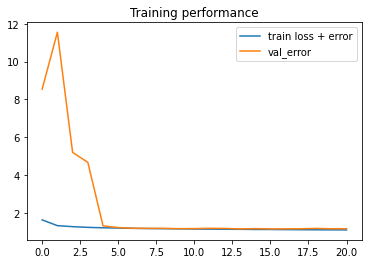

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

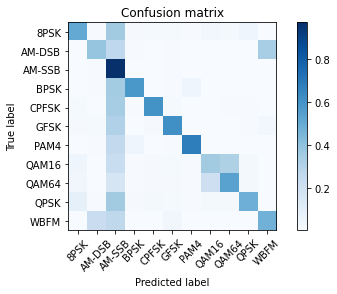

In [15]:
evaluationlib.plot_confusion_matrix(model, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08506686478454681


Overall Accuracy:  0.09205175600739371


Overall Accuracy:  0.0929657122658183


Overall Accuracy:  0.10822206605762473


Overall Accuracy:  0.14270231213872833


Overall Accuracy:  0.21661296097386323


Overall Accuracy:  0.33285560730920816


Overall Accuracy:  0.47238372093023256


Overall Accuracy:  0.5981540646077387


Overall Accuracy:  0.7117181883537024


Overall Accuracy:  0.7872185911401598


Overall Accuracy:  0.8315903353768482


Overall Accuracy:  0.8425047438330171


Overall Accuracy:  0.8541044776119403


Overall Accuracy:  0.8551873198847262


Overall Accuracy:  0.8618301130149472


Overall Accuracy:  0.8548685671973343


Overall Accuracy:  0.8555848063181647


Overall Accuracy:  0.8507737656595431


Overall Accuracy:  0.8612903225806452


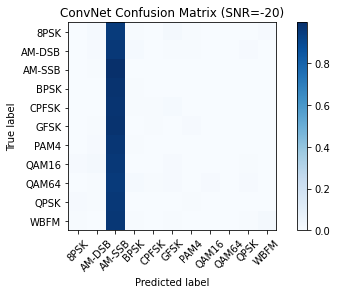

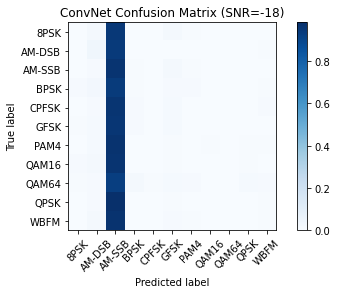

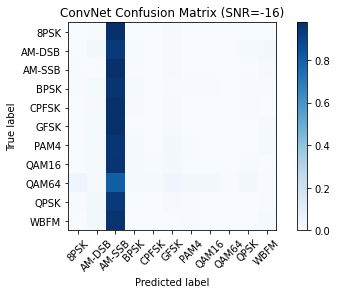

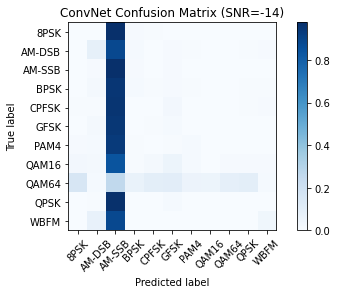

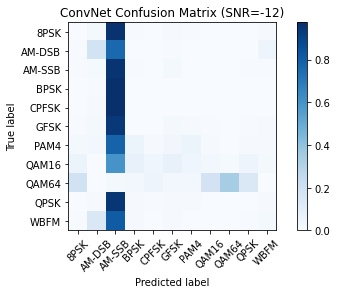

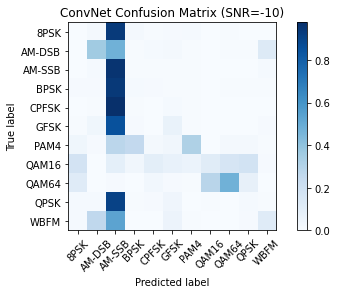

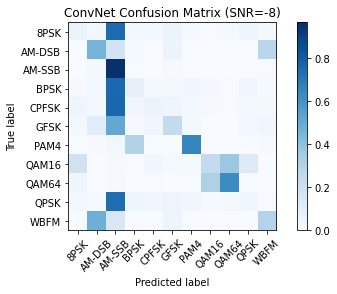

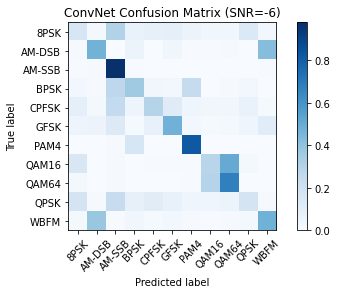

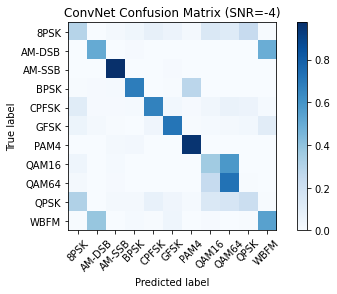

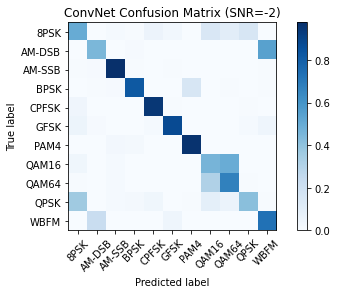

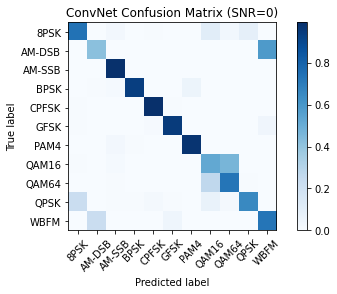

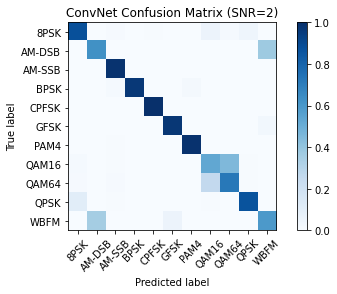

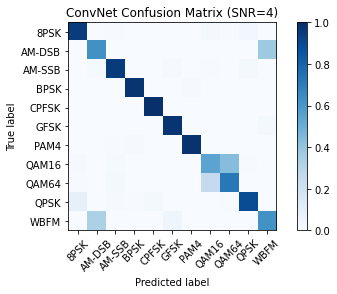

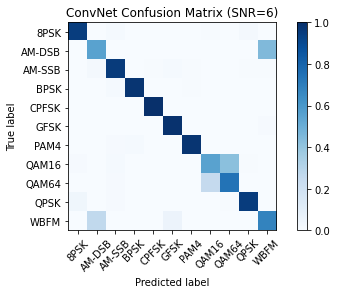

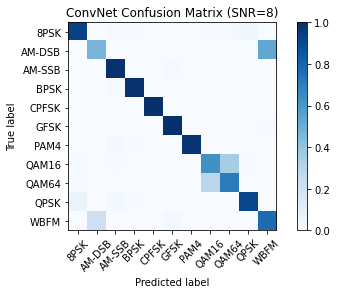

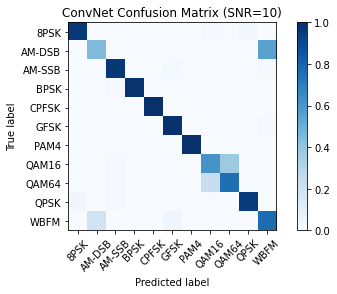

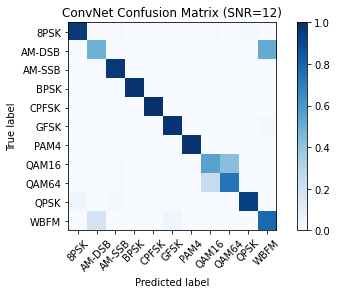

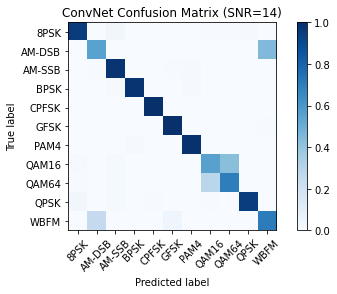

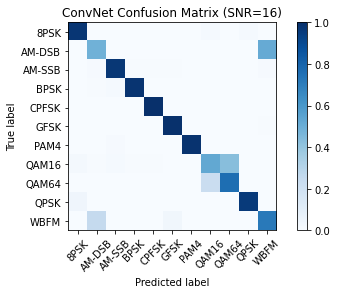

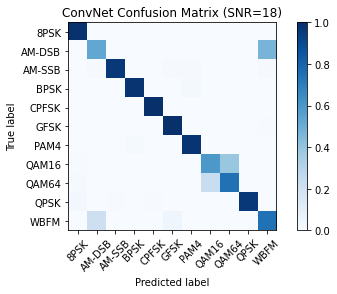

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,14,21,33,47,59,71,78,83,84,85,85,86,85,85,85,86


In [18]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

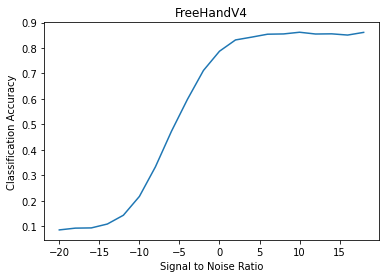

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)